In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import pandas as pd
data = pd.read_csv('D:/model/App_Mobile_Emotion/training_model/ChangeDataSet/emotion_dataset.csv')
data.head(20)

emotion                                             pixels     Usage
0         0  72 78 81 75 59 54 63 61 55 55 62 46 93 114 121...  Training
1         0  152 149 147 157 146 133 114 138 170 175 184 15...  Training
2         0  29 25 21 23 26 24 49 67 85 101 121 125 130 140...  Training
3         0  32 23 20 56 43 34 38 46 92 99 34 21 27 27 31 4...  Training
4         0  222 218 202 189 199 208 193 134 103 89 37 41 5...  Training
5         0  238 239 237 234 232 228 231 203 170 152 166 18...  Training
6         0  35 26 25 14 12 14 17 20 22 22 24 24 46 35 29 2...  Training
7         0  120 119 120 121 121 122 122 123 122 120 124 12...  Training
8         0  255 255 254 255 250 223 179 125 119 106 96 97 ...  Training
9         0  73 77 79 105 130 128 92 81 76 55 58 44 71 76 7...  Training
10        0  30 18 16 25 40 35 35 50 132 170 180 180 183 18...  Training
11        0  70 65 72 75 117 129 157 166 163 164 167 169 17...  Training
12        0  231 225 229 222 222 191 152 146 107 77 96 76 4...  Training
13        0  93 108 104 107 118 119 141 153 137 152 154 147...  Training
14        0  64 72 99 133 133 98 93 115 169 156 140 150 161...  Training
15        0  253 253 253 254 219 208 216 214 211 213 213 21...  Training
16        0  251 248 255 224 33 54 151 188 198 199 201 204 ...  Training
17        0  16 27 41 40 53 68 84 97 114 119 127 145 152 16...  Training
18        0  218 222 218 198 175 162 180 194 196 223 234 23...  Training
19        0  0 1 0 0 2 1 19 118 164 199 238 230 227 222 231...  Training

<Figure size 1400x800 with 0 Axes>

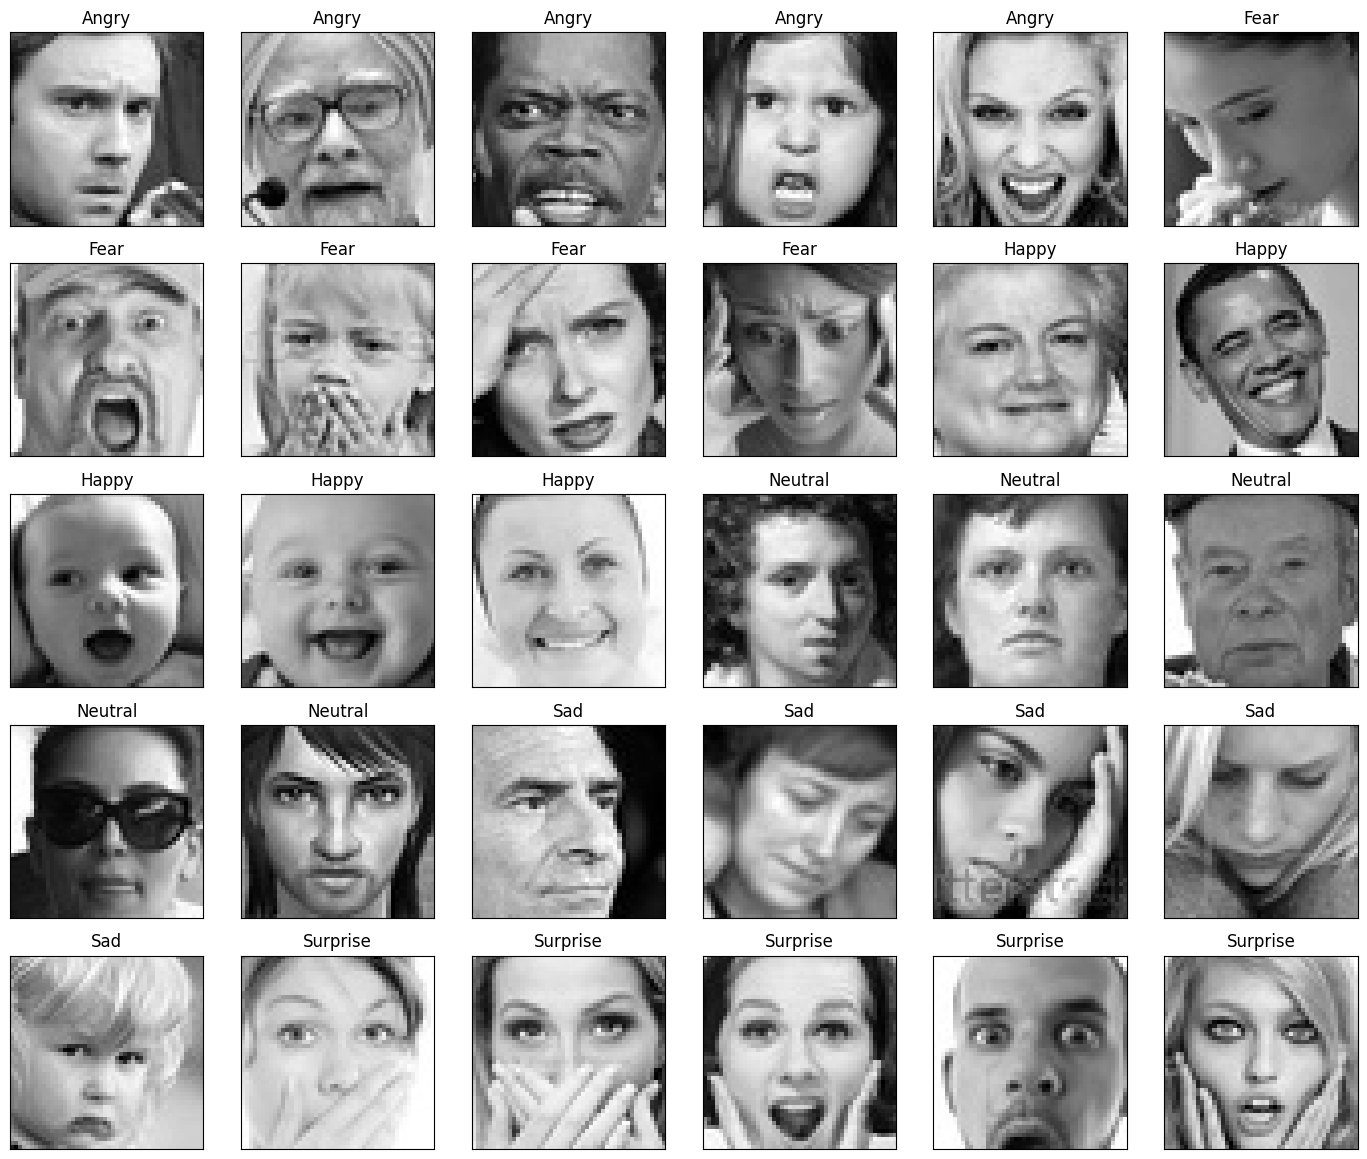

<Figure size 1400x800 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
label_to_text = {
    0: 'Angry',
    1: 'Fear',
    2: 'Happy',
    3: 'Neutral',
    4: 'Sad',
    5: 'Surprise'
}

fig = plt.figure(1, (14, 14))
k = 0

for label in sorted(data['emotion'].unique()):
    subset = data[data['emotion'] == label].head(5)  # L·∫•y 5 ·∫£nh ƒë·∫ßu c·ªßa m·ªói nh√£n
    for i in range(len(subset)):
        pixel_string = subset.iloc[i]['pixels']
        px = np.array(pixel_string.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(6, 6, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

plt.figure(figsize=(14, 8))

In [4]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
# --- C·∫•u h√¨nh ---
IMG_SIZE = 96    # Resize ·∫£nh nh·ªè h∆°n cho ResNet18 custom
NUM_CLASSES = 6

# --- 1. ƒê·ªçc d·ªØ li·ªáu ---
data = pd.read_csv('D:/model/App_Mobile_Emotion/training_model/ChangeDataSet/emotion_dataset.csv')
x_data = data['pixels']
y_data = data['emotion']

# --- 2. Oversampling ƒë·ªÉ c√¢n b·∫±ng nh√£n ---
oversampler = RandomOverSampler(sampling_strategy='auto')
x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1, 1), y_data)

# --- 3. Chuy·ªÉn chu·ªói pixel th√†nh m·∫£ng numpy ---
x_data = pd.Series(x_data.flatten())
x_data = np.array(list(map(str.split, x_data)), dtype=np.float32)
x_data /= 255.0   # Chu·∫©n h√≥a pixel v·ªÅ [0,1]
x_data = x_data.reshape(-1, 48, 48)  # ·∫¢nh grayscale ban ƒë·∫ßu

# --- 4. Resize l√™n 96x96 v√† chuy·ªÉn grayscale sang 3 k√™nh RGB ---
x_data_resized = []
for img in tqdm(x_data, desc="Resizing and converting to RGB"):
    resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize ·∫£nh v·ªÅ 96x96
    rgb_img = np.stack((resized_img,) * 3, axis=-1)     # Grayscale -> RGB 3 k√™nh
    x_data_resized.append(rgb_img)

x_data_resized = np.array(x_data_resized, dtype=np.float32)

# --- 5. One-hot encoding nh√£n ---
y_data = np.array(y_data).reshape(-1, 1)
y_data = to_categorical(y_data, num_classes=NUM_CLASSES)

# --- 6. Chia t·∫≠p hu·∫•n luy·ªán v√† ki·ªÉm tra ---
x_train, x_test, y_train, y_test = train_test_split(x_data_resized, y_data, test_size=0.1, random_state=45)

data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# --- 7. Ki·ªÉm tra k√≠ch th∆∞·ªõc ---
print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)


Resizing and converting to RGB: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42984/42984 [00:04<00:00, 8627.70it/s]


Train shape: (38685, 96, 96, 3) (38685, 6)
Test shape: (4299, 96, 96, 3) (4299, 6)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2  # TH√äM D√íNG N√ÄY

def conv_block(x, filters, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same', use_bias=False,
               kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False,
               kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False,
                          kernel_regularizer=l2(0.001))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet18(input_shape=(96, 96, 3), num_classes=6):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False,
               kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = conv_block(x, 64, strides=1)
    x = conv_block(x, 64, strides=1)

    x = conv_block(x, 128, strides=2)
    x = conv_block(x, 128, strides=1)

    x = conv_block(x, 256, strides=2)
    x = conv_block(x, 256, strides=1)

    x = conv_block(x, 512, strides=2)
    x = conv_block(x, 512, strides=1)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax',
                    kernel_regularizer=l2(0.001))(x)

    model = Model(inputs, outputs)
    return model

# Kh·ªüi t·∫°o model
model = build_resnet18()
model.summary()


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 96, 96, 3) ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d (Conv2D)     ‚îÇ (None, 48, 48,    ‚îÇ      9,408 ‚îÇ input_layer[0][0] ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization ‚îÇ (None, 48, 48,    ‚îÇ        256 ‚îÇ conv2d[0][0]      ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu (ReLU)        ‚îÇ (None, 48, 48,    ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d       ‚îÇ (None, 24, 24,    ‚îÇ          0 ‚îÇ re_lu[0][0]       ‚îÇ
‚îÇ (MaxPooling2D)      ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)   ‚îÇ (None, 24, 24,    ‚îÇ     36,864 ‚îÇ max_pooling2d[0]‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 24, 24,    ‚îÇ        256 ‚îÇ conv2d_1[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu_1 (ReLU)      ‚îÇ (None, 24, 24,    ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)   ‚îÇ (None, 24, 24,    ‚îÇ     36,864 ‚îÇ re_lu_1[0][0]     ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 11,189,190 (42.68 MB)

 Trainable params: 11,179,590 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/65
1209/1209 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 447ms/step - accuracy: 0.2954 - loss: 6.0509
Epoch 1: val_accuracy improved from -inf to 0.44336, saving model to best_resnet18_model.keras
1209/1209 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 566s 459ms/step - accuracy: 0.2954 - loss: 6.0506 - val_accuracy: 0.4434 - val_loss: 5.1005 - learning_rate: 1.0000e-04
Epoch 2/65
1209/1209 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 418ms/step - accuracy: 0.5258 - loss: 4.7958
Epoch 2: val_accuracy improved from 0.44336 to 0.47360, saving model to best_resnet18_model.keras
1209/1209 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 518s 429ms/step - accuracy: 0.5258 - loss: 4.7956 - val_accuracy: 0.4736 - val_loss: 4.4549 - learning_rate: 1.0000e-04
Epoch 3/65
1209/1209 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 407ms/step - accuracy: 0.6691 - loss: 3.8681
Epoch 3: val_accuracy improved from

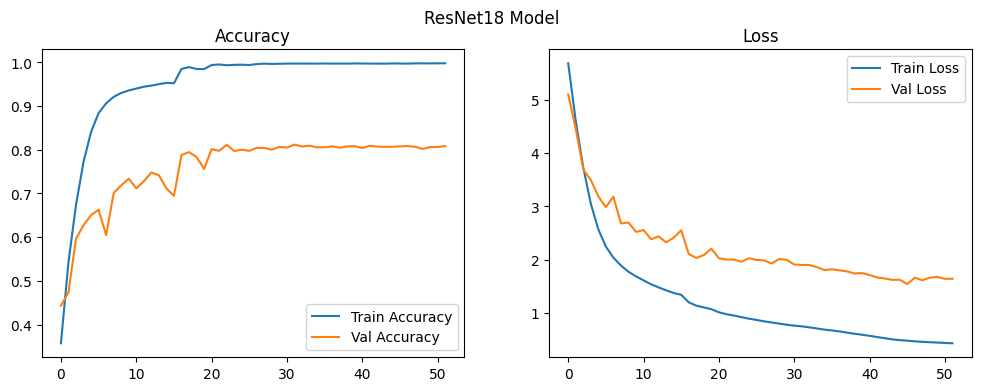

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Gi·∫£ s·ª≠ b·∫°n ƒë√£ chu·∫©n b·ªã s·∫µn d·ªØ li·ªáu x_train, y_train, x_test, y_test
# v·ªõi input shape = (96, 96, 3) ho·∫∑c thay ƒë·ªïi theo c·∫•u h√¨nh c·ªßa b·∫°n

# 1. Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2. Callback ƒë·ªÉ l∆∞u model t·ªët nh·∫•t
checkpoint = ModelCheckpoint(
    'best_resnet18_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    verbose=1,
    restore_best_weights=True
)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 3. Hu·∫•n luy·ªán model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=65,           # s·ªë epoch t√πy ch·ªânh
    batch_size=32,
    callbacks=[checkpoint, early_stopping, learning_rate_reduction],
    shuffle=True,
    verbose=1
    
)
model.save('resnet18_model.keras')  # L∆∞u model sau khi hu·∫•n luy·ªán
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.suptitle("ResNet18 Model")  # Ti√™u ƒë·ªÅ cho to√†n b·ªô figure
plt.show()


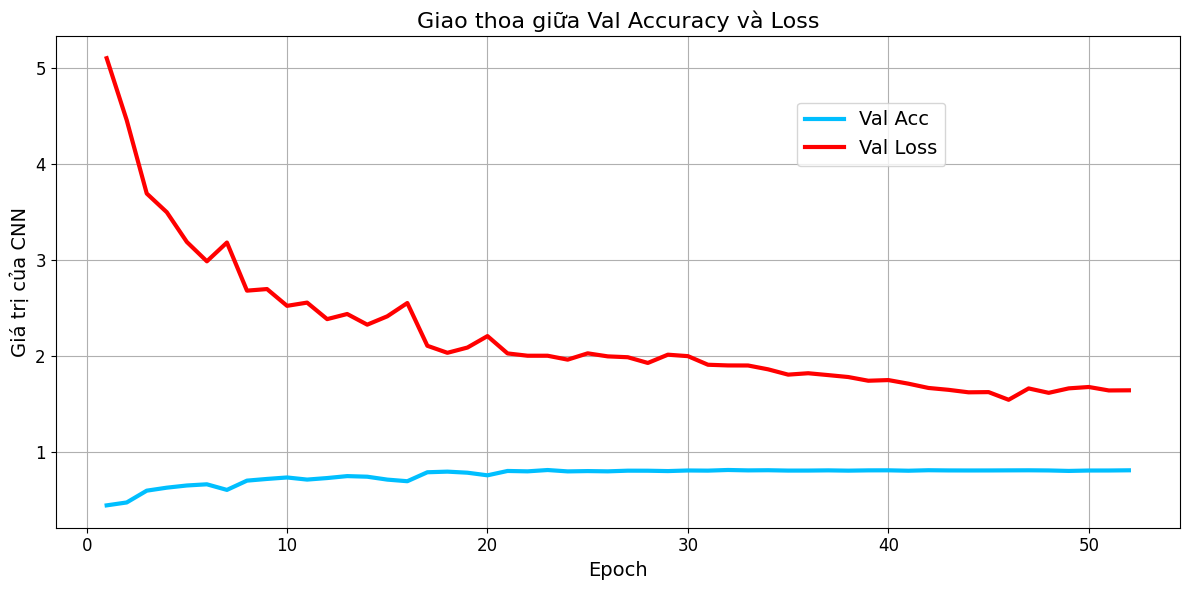

In [11]:
import matplotlib.pyplot as plt

# Gi·∫£ s·ª≠ history l√† k·∫øt qu·∫£ t·ª´ model.fit()
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(val_acc) + 1)

plt.figure(figsize=(12, 6))

# V·∫Ω val_accuracy
plt.plot(epochs, val_acc, color='deepskyblue', linewidth=3, label='Val Acc')

# V·∫Ω val_loss
plt.plot(epochs, val_loss, color='red', linewidth=3, label='Val Loss')

# C√†i ƒë·∫∑t tr·ª•c
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Gi√° tr·ªã c·ªßa CNN', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ch√∫ th√≠ch n·∫±m b√™n tr√°i
plt.legend(loc='center right', bbox_to_anchor=(0.8, 0.8), fontsize=14)

# Ti√™u ƒë·ªÅ
plt.title('Giao thoa gi·ªØa Val Accuracy v√† Loss', fontsize=16)

# Hi·ªÉn th·ªã
plt.grid(True)
plt.tight_layout()
plt.show()


135/135 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 97ms/step
üìã Classification Report:

              precision    recall  f1-score   support

       angry       0.84      0.82      0.83       728
        fear       0.81      0.81      0.81       735
       happy       0.81      0.76      0.78       728
     neutral       0.74      0.79      0.76       729
         sad       0.73      0.71      0.72       699
    surprise       0.91      0.97      0.94       680

    accuracy                           0.81      4299
   macro avg       0.81      0.81      0.81      4299
weighted avg       0.81      0.81      0.81      4299



C:\Users\DELL\AppData\Local\Temp\ipykernel_5736\1681813507.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


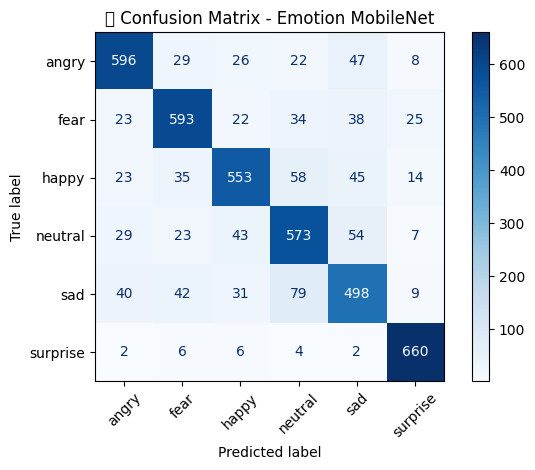

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# D·ª± ƒëo√°n x√°c su·∫•t
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# üìã In b√°o c√°o ph√¢n lo·∫°i v·ªõi nh√£n
print("üìã Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# üìä V·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("üìä Confusion Matrix - Emotion MobileNet")
plt.tight_layout()
plt.show()